Model signal.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

sampling_rate = 192000

# main signal frequency
frequency = sampling_rate/100
t = np.arange(0, 3*(1/frequency), (1/sampling_rate))
# taps
n = 4 
# main signal component
amplitude = 10
x0 = amplitude*np.sin(2*np.pi*frequency*t)
# components to be filtered
f_cutoff = (1/n)*sampling_rate
x1 = 0.3*amplitude*np.sin(2*np.pi*f_cutoff*t)
x2 = 0.2*amplitude*np.sin(2*np.pi*((1/n)+0.1)*sampling_rate*t)
x3 = 0.1*amplitude*np.sin(2*np.pi*((1/n)+0.2)*sampling_rate*t)
# gaussian noise
noise = np.random.normal(0, 1, len(t))
# complete signal
x = x0 + x1 + x2 + x3 + noise

Plot signal.

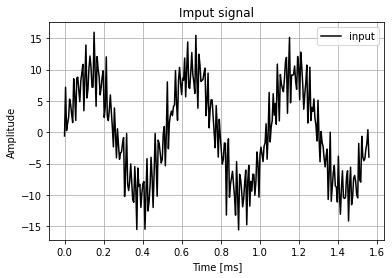

In [4]:
plt.plot(t*1000, x, label='input', color='black', marker='', linestyle='-')
plt.xlabel('Time [ms]')
plt.ylabel('Amplitude')
plt.title('Imput signal')
plt.legend()
plt.grid()
#plt.savefig('Imput signal.pdf')
plt.show()

In [6]:
def moving_average(x, n):           
    y = np.zeros(len(x)-(n-1))
    for i in range(0, len(y)):
        y[i] = np.sum(x[i:i+n])/n
    return y

def moving_average_vhdl(x, n):           
    y = np.zeros(len(x)-(n-1))
    for i in range(0, len(y)):
        y[i] = int(np.sum(x[i:i+n])/n) 
    return y

1 filters, each with 30 taps


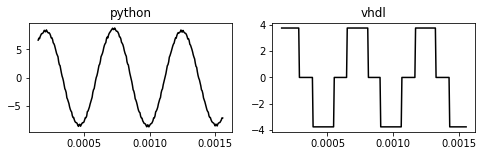

2 filters, each with 15 taps


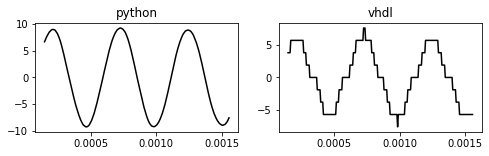

3 filters, each with 10 taps


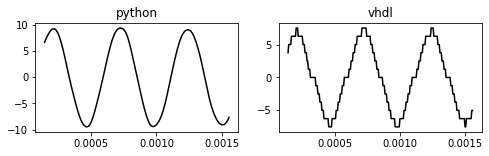

5 filters, each with 6 taps


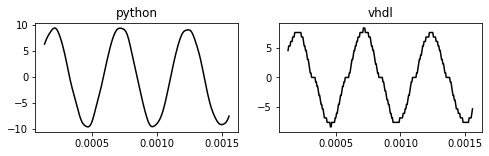

6 filters, each with 5 taps


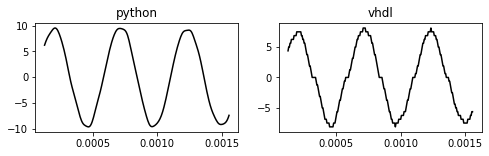

10 filters, each with 3 taps


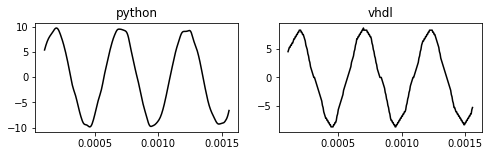

15 filters, each with 2 taps


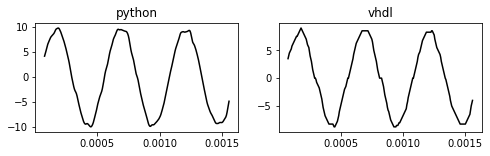

In [42]:
# fix total number of taps to 20
taps = 30

# simulate 5 cascades
mean_error = np.zeros(7)
m = 0 # counter

for N in [1,2,3,5,6,10,15]: # N = number of filters, each one with 20/N taps
   
    # pre-processing for vhdl
    s = 1/max(abs(x)) # scale input to be between 1 and -1
    c = (127/taps)*N # max imput value
    x_vhdl = np.array([int(i*s*c) for i in x])
    
    # initialization
    y = np.zeros(len(x))
    y_vhdl = np.zeros(len(x_vhdl))
               
    for i in range(N): # for each N apply the cascade of N filters
         
        if i == 0: # first fir filter
            y = moving_average(x, int(taps/N))
            y_vhdl = moving_average_vhdl(x_vhdl, int(taps/N))
        else: # cascade
            y = moving_average(y, int(taps/N))
            y_vhdl = moving_average_vhdl(y_vhdl, int(taps/N))
    
    # post-processing for vhdl
    y_vhdl = y_vhdl/(s*c)
   
    # plot
    print(str(N)+' filters, each with '+str(int(taps/N))+' taps')
    fig, ax = plt.subplots(1, 2, figsize=(8,2))
    ax[0].plot(t[taps-N:], y, color='black', marker='', linestyle='-')
    ax[0].set_title('python')
    ax[1].plot(t[taps-N:], y_vhdl, color='black', marker='', linestyle='-')
    ax[1].set_title('vhdl')
    plt.show()
    
    # compute mean error due to data-processing
    mean_error[m] = np.sum(abs(y-y_vhdl))/len(y)
    m += 1

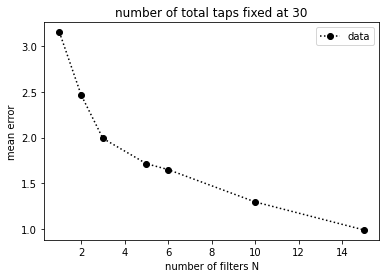

In [46]:
plt.plot([1,2,3,5,6,10,15], mean_error, label='data', color='black', marker='o', linestyle=':')
mean_error_th = np.array([(max(abs(x))/127)*(taps)*((1/np.sqrt(12))+1/N) for N in [1,2,3,5,6,10,15]])
#plt.plot([1,2,3,5,6,10,15], mean_error_th, 'C1', label='1/N')
plt.xlabel('number of filters N')
plt.ylabel('mean error')
plt.title('number of total taps fixed at '+str(taps))
plt.legend();


In [47]:
# simulate cascades of filters, each with a fixed number of taps
mean_error = np.zeros((5, 10))
m = 0 # counter

for n in [2,4,6,8,10]: # n = number of taps, the same for each filter of the cascades

    # pre-processing for vhdl
    s = 1/max(abs(x)) # scale input to be between 1 and -1
    c = (127/n) # max imput value
    x_vhdl = np.array([int(i*s*c) for i in x])
    
    # initialization
    y = np.zeros(len(x))
    y_vhdl = np.zeros(len(x_vhdl))
               
    for N in range(10): # apply the cascade of N filters, each with n taps
         
        if N == 0: # first fir filter
            y = moving_average(x, n)
            y_vhdl = moving_average_vhdl(x_vhdl, n)
        else: # cascade
            y = moving_average(y, n)
            y_vhdl = moving_average_vhdl(y_vhdl, n) 

        # compute mean error due to data-processing
        mean_error[m,N] = np.sum(abs(y-(y_vhdl/(s*c))))/len(y)
        
    m += 1

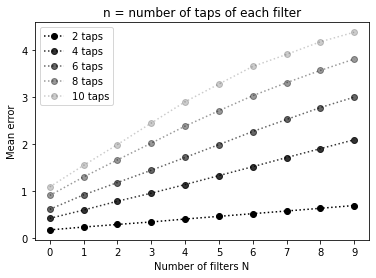

In [48]:
N = np.arange(10)
taps = [2,4,6,8,10]
for i in range(5):
    a = 1 - 0.2*i
    plt.plot(N, mean_error[i,:], label=str(taps[i])+' taps', alpha=a, color='black', marker='o', linestyle=':')
    #plt.plot(N, (max(abs(x))/127)*((1/np.sqrt(12))*N+1)*taps[i], 'C1', alpha=a)

plt.xlabel('Number of filters N')
plt.xticks(np.arange(0,10,1))
plt.ylabel('Mean error')
plt.title('n = number of taps of each filter')
plt.legend();